In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import scipy.optimize
import csv
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold

float_formatter = lambda x : "%.5f" %x
np.set_printoptions(formatter =  {'float_kind' : float_formatter})

# Function definitions for linear/polynomial/RBF kernels

In [8]:
def linear_kernel2(x,xp):
    return x.dot(xp.T)

def poly_kernel2(x, xp, alpha = 1, deg = 2) :
    return np.power(x.dot(xp.T) + alpha, deg)

def RBF_kernel2(x, xp, sigma = 1) :
    return np.exp(-(np.linalg.norm(x.T - xp.T, ord =2) ** 2)/ (2 * (sigma ** 2)))


In [9]:
#regression call for kernelized ridge regression

def ridge_reg(inputval,outputval,targetset,truthset,ktype,lambdavals=[],sigmavals=[],alphavals=[],polyvals=[]) :
    '''the following function will perform kernel ridge regression with
       respective kernel and find the one with lowest MSE'''
    allresult = []
    for a in lambdavals:
        if ktype == 'linear':
            testpred = simplekrr(inputval,outputval,targetset,ktype='linear',lambdaval=a)
            mse = mean_squared_error(testpred,truthset)
            allresult.append([a, mse])
        elif ktype == 'poly':
            for b in alphavals:
                for c in polyvals:
                    testpred = simplekrr(inputval,outputval,targetset,ktype='poly',lambdaval=a, alphaval=b, poly_degree=c)
                    mse = mean_squared_error(testpred,truthset)
                    allresult.append([a, b, c, mse])
        elif ktype == 'RBF':
            for b in sigmavals:
                testpred = simplekrr(inputval,outputval,targetset,ktype='RBF',lambdaval=a,sigmaval=b)
                mse = mean_squared_error(testpred,truthset)
                allresult.append([a, b, mse])
    return np.array(allresult)

# Kernel ridge function

In [10]:
#the proper functioning of linear/poly/RBF kernels with their specific parameters

def simplekrr(inputval,outputval,targetset,ktype='poly',lambdaval=0,sigmaval=1,alphaval=1,poly_degree=2):
    '''for polynomial kernel : alpha, degree, lambda are the important parameters
       for linear kernel : lambda is the important parameter, for RBF kernel : sigma and lambda
       are the important parameters. The following functions takes care of the calculations that 
       that lead to the working of the kernels. We loop through each target.'''
    for n in targetset:
        #print ("calculate for target: ",n)
        # kxT section #
        # create x,xn arrays
        xval = np.copy(inputval).astype(float)
        #print(xval)

        # calculate kxT for them
        if ktype == 'poly':
            xvaltrans = poly_kernel2(xval,n,alphaval,poly_degree)
        elif ktype == 'linear':
            xvaltrans = linear_kernel2(xval,n)
        elif ktype == 'RBF':
            xvaltrans = np.array([])
            for idx,x in enumerate(xval):
                xvaltrans = np.append(xvaltrans,np.array([RBF_kernel2(x,n,sigmaval)]))
        else:
            print('unknown kernel')
        #print('k_x_xprime:\n',xvaltrans)
        
        # (K+lambdaIN)^-1 section
        # calculate bigK

        for m in inputval:
            #print(m)
            SubK = np.copy(inputval).astype(float)
            if ktype == 'poly':
                SubKResult = poly_kernel2(SubK,m)
            elif ktype == 'linear':
                SubKResult = linear_kernel2(SubK,m)
            elif ktype == 'RBF':
                SubKResult = np.array([])
                for idx,x in enumerate(SubK):
                    SubKResult = np.append(SubKResult,np.array([RBF_kernel2(x,m,sigmaval)]))
            else:
                print('unknown kernel')
            #print(SubKResult)
            if 'BigK' in locals():
                BigK = np.vstack([BigK,np.matrix(SubKResult)])
            else:
                BigK = np.matrix(SubKResult)
        #print('BigK ',BigK)
        # calculate lambdaIN
        identmat = np.identity(inputval.shape[0])
        lambdaIN = lambdaval*identmat
        #print(lambdaIN)
        if ktype == 'RBF':
            KlambdaINinv = np.linalg.inv(BigK)
        else:
            KlambdaINinv = np.linalg.inv(BigK + lambdaIN)
        #print('Klambdainv',KlambdaINinv)
        
        totval = xvaltrans * KlambdaINinv
        #print(totval)
        
        # t section
        tval = np.transpose(np.asmatrix(outputval))

        # final calculation
        result = xvaltrans * KlambdaINinv * tval
        
        del(BigK) # reset BigK for next iteration

        #print ("result is ",result.item(0))
        
        # append result to return value
        if 'retval' in locals():
            retval = np.append(retval,result.item(0))
        else:
            retval = np.array([result.item(0)])
    
    # Return the result(s)
    return retval

# WORKING OF MODELS ON SAMPLE VALUES

In [11]:
# this is a multiplication operation on two-dimensional input
# i.e., y = x0 * x1
mlinput = np.array([[2,3], [2,4], [3,5]]) # x_train
mloutput = np.array([6, 8, 15]) # y_train
mltest = np.array([[3,4],[4,5]]) # x_test
testtruth = np.array([12,20]) # the real/correct y value of x_test
print 'True value for Y : ',testtruth
print '\n'

#hyperparameters
lmbdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
alphas = [1, 2, 3, 4, 5]
polys = [-1, 0, 0.5, 1, 2]
sgmas = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 3]

#Linear Kernelized Ridge Regression
result = ridge_reg(mlinput,mloutput,mltest,testtruth,'linear',lmbdas)
result = result[result[:, 1].argsort()] # sort based on MSE
best_linear_lambda = result[0,0] # grab the best parameters
print 'Linear Y predict: ',simplekrr(mlinput,mloutput,mltest,ktype='linear',lambdaval=best_linear_lambda)

#Polynomial Kernelized Ridge Regression
result = ridge_reg(mlinput,mloutput,mltest,testtruth,'poly',lmbdas,sigmavals=[],alphavals=alphas,polyvals=polys)
result = result[result[:, 3].argsort()] # sort based on MSE
best_poly_lambda = result[0,0]
best_poly_alpha = result[0,1]
best_poly_degree = result[0,2]
print'Polynomial Y predict: ',simplekrr(mlinput,mloutput,mltest,ktype='poly',lambdaval=best_poly_lambda,
                              alphaval=best_poly_alpha,poly_degree=best_poly_degree)

#RBF Kernelized Ridge Regression
result = ridge_reg(mlinput,mloutput,mltest,testtruth,'RBF',lmbdas,sigmavals=sgmas)
result = result[result[:, 2].argsort()] # sort based on MSE
best_RBF_lambda = result[0,0]
best_RBF_sigma = result[0,1]
print 'RBF Y predict: ',simplekrr(mlinput,mloutput,mltest,ktype='RBF',lambdaval=best_RBF_lambda,
                              sigmaval=best_RBF_sigma)

True value for Y :  [12 20]


Linear Y predict:  [11.88880 15.55542]
Polynomial Y predict:  [11.98725 19.99571]
RBF Y predict:  [12.79741 17.92696]


# WORKING OF KERNELS ON RANDOMLY GENERATED TRIVIAL DATASET
# 1. Divide testdata into Train(64%), Validate(16%) and Test(20%)
# 2. Run Hyper Parameter regression to find the best parameters based on MSE
# 3. Find MSE of Model + best param against Test Data
# 4. Compare with Scikit Learn MSE to show our code is correct
# 5. Plot our model+best param prediction against truth of test data

In [14]:
# Generate sample data
rng = np.random.RandomState(0)

X = 5 * rng.rand(100, 1)
Y = np.sin(X).ravel()

# Add noise to targets
Y[::5] += (0.5 - rng.rand(X.shape[0] // 5))

# Split into train/validate and test
num_trainval = int(math.floor(X.shape[0] * 0.8))

X_test = X[num_trainval : X.shape[0]]
Y_test = Y[num_trainval : X.shape[0]]
X_trainval = X[:num_trainval]
Y_trainval = Y[:num_trainval]

Cross validation
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Best train/validate linear model parameter (lambda MSE) 1.0   0.380968034463
Best train/validate polynomial model parameter (lambda alpha poly MSE) 1e-05   1.0   2.0   0.0593009453488
Best train/validate gaussian model parameter (lambda sigma MSE) 1e-05   0.01   0.190734130076

Group7 linear kernel MSE against test set:  0.353336288905
Group7 polynomial kernel MSE against test set:  0.0365414811061
Group7 gaussian kernel MSE against test set:  0.164028567856
Scikit linear kernel MSE against test set:  0.353336288905
Scikit polynomial kernel MSE against test set:  0.0365414828654
Scikit RBF kernel MSE against test set:  0.164029682088


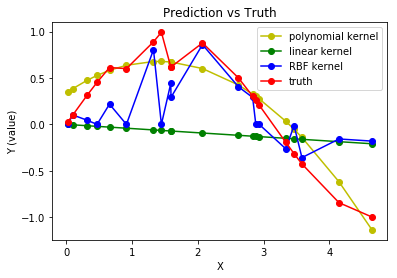

In [31]:
# Initialize hyper parameters
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
alphas = [1, 2, 3, 4, 5]
polys = [-1, 0, 0.5, 1, 2]
sigmas = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 3]

# Perform 5-fold cross validation on train/validate
kf = KFold(n_splits=5)

kf.get_n_splits(X_trainval)

kfoldstep = 0
best_linear_mse = None
best_poly_mse = None
best_RBF_mse = None
print 'Cross validation'

for train_idx, validate_idx in kf.split(X_trainval):
    kfoldstep += 1
    print 'Fold: ',kfoldstep
    mlinput, mltest = X_trainval[train_idx], X_trainval[validate_idx]
    mloutput, testtruth = Y_trainval[train_idx], Y_trainval[validate_idx]
    
    #
    # Find the best Parameter for each kernel
    #

    # Linear Kernelized Ridge Regression
    result = ridge_reg(mlinput,mloutput,mltest,testtruth,'linear',lmbdas)
    result = result[result[:, 1].argsort()] # sort based on MSE
    #print 'Fold ',kfoldstep,' lambda mse ',result[0,:]
    if (result[0,1] < best_linear_mse) or (best_linear_mse == None) :
        best_linear_mse = result[0,1]
        best_linear_lambda = result[0,0]
    
    #Polynomial Kernelized Ridge Regression
    result = ridge_reg(mlinput,mloutput,mltest,testtruth,'poly',lmbdas,sigmavals=[],alphavals=alphas,polyvals=polys)
    result = result[result[:, 3].argsort()] # sort based on MSE
    if (result[0,3] < best_poly_mse) or (best_poly_mse == None) :
        best_poly_lambda = result[0,0]
        best_poly_alpha = result[0,1]
        best_poly_degree = result[0,2]
        best_poly_mse = result[0,3]

    #RBF Kernelized Ridge Regression
    result = ridge_reg(mlinput,mloutput,mltest,testtruth,'RBF',lmbdas,sigmavals=sgmas)
    result = result[result[:, 2].argsort()] # sort based on MSE
    if (result[0,2] < best_RBF_mse) or (best_RBF_mse == None) :
        best_RBF_lambda = result[0,0]
        best_RBF_sigma = result[0,1]
        best_RBF_mse = result[0,2]

# final run against test set and report the MSE
Y_test_pred_linear = simplekrr(mlinput,mloutput,X_test,ktype='linear',lambdaval=best_linear_lambda)
linear_mse = mean_squared_error(Y_test_pred_linear,Y_test)
Y_test_pred_poly = simplekrr(mlinput,mloutput,X_test,ktype='poly',lambdaval=best_poly_lambda,
                             alphaval=best_poly_alpha,poly_degree=best_poly_degree)
Poly_mse = mean_squared_error(Y_test_pred_poly,Y_test)
Y_test_pred_rbf = simplekrr(mlinput,mloutput,X_test,ktype='RBF',lambdaval=best_RBF_lambda,
                            sigmaval=best_RBF_sigma)
RBF_mse = mean_squared_error(Y_test_pred_rbf,Y_test)

print 'Best train/validate linear model parameter (lambda MSE)',best_linear_lambda,' ', best_linear_mse
print 'Best train/validate polynomial model parameter (lambda alpha poly MSE)',best_poly_lambda,' ',best_poly_alpha,' ',best_poly_degree,' ',best_poly_mse
print 'Best train/validate gaussian model parameter (lambda sigma MSE)',best_RBF_lambda,' ',best_RBF_sigma,' ',best_RBF_mse

#
# Compare our result against scikit
#
# linear kernel
clf = KernelRidge(kernel='linear',alpha=best_linear_lambda)
clf.fit(mlinput, mloutput)
Y_test_pred_linear_scikit = clf.predict(X_test)
scikit_linear_mse = mean_squared_error(Y_test_pred_linear_scikit,Y_test)
# polynomial kernel
clf = KernelRidge(kernel='polynomial',alpha=best_poly_lambda,coef0=best_poly_alpha, degree=best_poly_degree)
clf.fit(mlinput, mloutput)
Y_test_pred_poly_scikit = clf.predict(X_test)
scikit_poly_mse = mean_squared_error(Y_test_pred_poly_scikit,Y_test)
# rbf kernel
scikitgamma = 1/(2*(best_RBF_sigma**2))
clf = KernelRidge(kernel='rbf',alpha=best_RBF_lambda,gamma=scikitgamma)
clf.fit(mlinput, mloutput)
Y_test_pred_gauss_scikit = clf.predict(X_test)
scikit_RBF_mse = mean_squared_error(Y_test_pred_gauss_scikit,Y_test)


print '\nGroup7 linear kernel MSE against test set: ',linear_mse
print 'Group7 polynomial kernel MSE against test set: ',Poly_mse
print 'Group7 gaussian kernel MSE against test set: ',RBF_mse
print 'Scikit linear kernel MSE against test set: ',scikit_linear_mse
print 'Scikit polynomial kernel MSE against test set: ',scikit_poly_mse
print 'Scikit RBF kernel MSE against test set: ',scikit_RBF_mse

# Plot
Xplot, Yplot = zip(*sorted(zip(X_test, Y_test_pred_poly)))
plt.plot(Xplot,Yplot, 'o-', color="y" , label="polynomial kernel")
Xplot, Yplot = zip(*sorted(zip(X_test, Y_test_pred_linear)))
plt.plot(Xplot,Yplot, 'o-', color="g" , label="linear kernel")
Xplot, Yplot = zip(*sorted(zip(X_test, Y_test_pred_rbf)))
plt.plot(Xplot,Yplot, 'o-', color="b" , label="RBF kernel")
Xplot, Yplot = zip(*sorted(zip(X_test, Y_test)))
plt.plot(Xplot,Yplot, 'o-', color="r" , label="truth")

plt.xscale("linear")
plt.yscale("linear")
plt.xlabel("X")
plt.ylabel("Y (value)")
plt.title('Prediction vs Truth')
plt.legend(loc="best")

plt.show()

# clear the plot
plt.clf()
plt.cla()
plt.close()


# WORKING OF KERNELS ON STOCK_DATASET

In [32]:
X = np.ones([63, 7], dtype = np.float64)
Y = np.ones([63], dtype = np.float64)

In [33]:
rowNum = 0
with open('stock_portfolio_performance_data_set.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if rowNum == 0:
            rowNum += 1
        else:
            col = 0
            colNum = 0
            for col in row:
                if colNum != 6:
                    X[rowNum - 1, colNum + 1] = col
                else:
                    Y[rowNum - 1] = col
                colNum += 1
            rowNum += 1

print (X[23,:])
print (Y[23])

[1.00000 0.33300 0.00000 0.33300 0.33300 0.00000 0.00000]
0.164


In [34]:
# Split into train/validate and test
num_trainval = int(math.floor(X.shape[0] * 0.8))

X_test = X[num_trainval : X.shape[0]]
Y_test = Y[num_trainval : X.shape[0]]
X_trainval = X[:num_trainval]
Y_trainval = Y[:num_trainval]

In [35]:
# hyper parameters
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
alphas = [1, 2, 3, 4, 5]
polys = [-1, 0, 0.5, 1, 2]
sigmas = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 3]

best_linear_mse = None
best_poly_mse = None
best_RBF_mse = None

In [36]:
# Perform 5-fold cross validation on train/validate
kf = KFold(n_splits=5)

kf.get_n_splits(X_trainval)

kfoldstep = 0
print 'Cross validation'

for train_idx, validate_idx in kf.split(X_trainval):
    kfoldstep += 1
    print 'Fold: ',kfoldstep
    mlinput, mltest = X_trainval[train_idx], X_trainval[validate_idx]
    mloutput, testtruth = Y_trainval[train_idx], Y_trainval[validate_idx]
    
    # Linear Kernelized Ridge Regression
    result = ridge_reg(mlinput,mloutput,mltest,testtruth,'linear',lmbdas)
    result = result[result[:, 1].argsort()] # sort based on MSE
    if (result[0,1] < best_linear_mse) or (best_linear_mse == None) :
        best_linear_mse = result[0,1]
        best_linear_lambda = result[0,0]
    
# final run against test set and report the MSE
Y_test_pred = simplekrr(mlinput,mloutput,X_test,ktype='linear',lambdaval=best_linear_lambda)
linear_mse = mean_squared_error(Y_test_pred,Y_test)

print 'Best lambda is : ', best_linear_lambda
print '\nFinal linear kernel MSE against test set: ',linear_mse

Cross validation
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Best lambda is :  1e-05

Final linear kernel MSE against test set:  0.000510426178768


In [37]:
# Perform 5-fold cross validation on train/validate
kf = KFold(n_splits=5)

kf.get_n_splits(X_trainval)

kfoldstep = 0
print 'Cross validation'

for train_idx, validate_idx in kf.split(X_trainval):
    kfoldstep += 1
    print 'Fold: ',kfoldstep
    mlinput, mltest = X_trainval[train_idx], X_trainval[validate_idx]
    mloutput, testtruth = Y_trainval[train_idx], Y_trainval[validate_idx]
    
    #Polynomial Kernelized Ridge Regression
    result = ridge_reg(mlinput,mloutput,mltest,testtruth,'poly',lmbdas,sigmavals=[],alphavals=alphas,polyvals=polys)
    result = result[result[:, 3].argsort()] # sort based on MSE
    if (result[0,3] < best_poly_mse) or (best_poly_mse == None) :
        best_poly_lambda = result[0,0]
        best_poly_alpha = result[0,1]
        best_poly_degree = result[0,2]
        best_poly_mse = result[0,3]

# final run against test set and report the MSE
Y_test_pred = simplekrr(mlinput,mloutput,X_test,ktype='poly',lambdaval=best_poly_lambda,
                        alphaval=best_poly_alpha,poly_degree=best_poly_degree)
Poly_mse = mean_squared_error(Y_test_pred,Y_test)
print 'Best lambda : ',best_poly_lambda
print 'Best r : ', best_poly_alpha
print 'Best M : ', best_poly_degree
print '\nFinal Polynomial kernel MSE against test set: ',Poly_mse

Cross validation
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Best lambda :  0.0001
Best r :  1.0
Best M :  2.0

Final Polynomial kernel MSE against test set:  8.53074076464e-05


In [38]:
# Perform 5-fold cross validation on train/validate
kf = KFold(n_splits=5)

kf.get_n_splits(X_trainval)

kfoldstep = 0
print 'Cross validation'

for train_idx, validate_idx in kf.split(X_trainval):
    kfoldstep += 1
    print 'Fold: ',kfoldstep
    mlinput, mltest = X_trainval[train_idx], X_trainval[validate_idx]
    mloutput, testtruth = Y_trainval[train_idx], Y_trainval[validate_idx]
    
    #RBF Kernelized Ridge Regression
    result = ridge_reg(mlinput,mloutput,mltest,testtruth,'RBF',lmbdas,sigmavals=sgmas)
    result = result[result[:, 2].argsort()] # sort based on MSE
    if (result[0,2] < best_RBF_mse) or (best_RBF_mse == None) :
        best_RBF_lambda = result[0,0]
        best_RBF_sigma = result[0,1]
        best_RBF_mse = result[0,2]
    
# final run against test set and report the MSE
Y_test_pred = simplekrr(mlinput,mloutput,X_test,ktype='RBF',lambdaval=best_RBF_lambda,
                        sigmaval=best_RBF_sigma)
RBF_mse = mean_squared_error(Y_test_pred,Y_test)
print 'Best lambda : ', best_RBF_lambda
print 'Best sigma : ', best_RBF_sigma

print '\nFinal RBF kernel MSE against test set: ',RBF_mse

Cross validation
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Best lambda :  0.1
Best sigma :  1.0

Final RBF kernel MSE against test set:  3.99012261199e-05


In [39]:
print 'BEST MSE Score : ', RBF_mse, '\nRBF[Gaussian] kernel is the better kernel of the three'

BEST MSE Score :  3.99012261199e-05 
RBF[Gaussian] kernel is the better kernel of the three


In [40]:
#
# Compare our result against scikit
#
# linear kernel
clf = KernelRidge(kernel='linear',alpha=best_linear_lambda)
clf.fit(mlinput, mloutput)
Y_test_pred_linear_scikit = clf.predict(X_test)
scikit_linear_mse = mean_squared_error(Y_test_pred_linear_scikit,Y_test)
# polynomial kernel
clf = KernelRidge(kernel='polynomial',alpha=best_poly_lambda,coef0=best_poly_alpha, degree=best_poly_degree)
clf.fit(mlinput, mloutput)
Y_test_pred_poly_scikit = clf.predict(X_test)
scikit_poly_mse = mean_squared_error(Y_test_pred_poly_scikit,Y_test)
# rbf kernel
scikitgamma = 1/(2*(best_RBF_sigma**2))
clf = KernelRidge(kernel='rbf',alpha=best_RBF_lambda,gamma=scikitgamma)
clf.fit(mlinput, mloutput)
Y_test_pred_gauss_scikit = clf.predict(X_test)
scikit_RBF_mse = mean_squared_error(Y_test_pred_gauss_scikit,Y_test)

print '\nGroup7 linear kernel MSE against test set: ',linear_mse
print 'Group7 polynomial kernel MSE against test set: ',Poly_mse
print 'Group7 gaussian kernel MSE against test set: ',RBF_mse
print 'Scikit linear kernel MSE against test set: ',scikit_linear_mse
print 'Scikit polynomial kernel MSE against test set: ',scikit_poly_mse
print 'Scikit RBF kernel MSE against test set: ',scikit_RBF_mse


Group7 linear kernel MSE against test set:  0.000510426178768
Group7 polynomial kernel MSE against test set:  8.53074076464e-05
Group7 gaussian kernel MSE against test set:  3.99012261199e-05
Scikit linear kernel MSE against test set:  0.000510426178968
Scikit polynomial kernel MSE against test set:  8.66898093262e-05
Scikit RBF kernel MSE against test set:  3.93821741036e-05
